<a href="https://colab.research.google.com/github/franitaa/ADHD-EEG-Game/blob/main/ADHD_EEG_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de ADHD a través de un juego basado en EEG

*   Francesca Rondinella (61031)
*   Nicolás Suárez Durrels (62468)


## Dudas

- Para sujetos non-ADHD, hay data de los canales de EEG y data ya dividida en bandas de frecuencia. Para los sujetos ADHD sólo está la data de las bandas, y por eso nos quedamos solo con esa información en ambos casos para el análisis. Está ok como approach?
- Observando los espectrogramas parecerían tener aún ruido de línea (línea en 50 Hz), o sea que no está 100% procesada la data de las bandas de frecuencia. Estamos decidiendo cuál es la mejor manera de filtrar datos de este tipo, ya que no tenemos las señales crudas.
- Agregamos las columnas que usan en el paper? Nos da dudas, porque son ratios entre las distintas bandas de frecuencia (literalmente, theta/gamma y así). No sabemos si no sería como repetir los datos.
- La frecuencia de muestreo es 125 Hz, según como lo calculamos con los timestamps que están en los datos de no-ADHD. Es correcto pensar que para las bandas de frecuencia, como usan ventanas de tamaño 5 sin overlap, la fs = 125 / 5 = 25 Hz?.



## Imports y carga de datos

In [1]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.2 MB/s eta 0:00:00


In [2]:
#Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram
from sklearn.manifold import TSNE
from umap import UMAP

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_folder_path = '/content/drive/MyDrive/New EEG Data'

# dictionaries
adhd_emotive = {}
adhd_keyboard = {}
non_adhd_emotive = {}
non_adhd_keyboard = {}

def read_and_categorize_csv_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # categoria segun path
                relative_path = os.path.relpath(file_path, main_folder_path)
                parts = relative_path.split(os.sep)

                if len(parts) >= 3:
                    category = parts[0]  # ADHD o Non-ADHD
                    subcategory = parts[2]  # Emotive o Keyboard

                    #df = pd.read_csv(file_path)
                    df = pd.read_csv(file_path, index_col=False).dropna(how='all')

                    #selected_columns = ['Theta', ' Alpha', ' Low_beta', ' High_beta', ' Gamma ']
                    #filtered_df  = df[selected_columns]
                    # Strip leading/trailing spaces from column names
                    df.columns = df.columns.str.strip()
                    #print("Available columns:", df.columns.tolist())
                    #print(parts)

                    selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

                    if all(column in df.columns for column in selected_columns):
                      filtered_df  = df[selected_columns]
                      if category == 'ADHD' and subcategory == 'Emotiv':
                          adhd_emotive[relative_path] = df
                      elif category == 'ADHD' and subcategory == 'Keyboard':
                          adhd_keyboard[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Emotive':
                          non_adhd_emotive[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Keyboard':
                          non_adhd_keyboard[relative_path] = df



read_and_categorize_csv_files(main_folder_path)

print("ADHD - Emotive:", adhd_emotive.keys())
print("ADHD - Keyboard:", adhd_keyboard.keys())
print("Non-ADHD - Emotive:", non_adhd_emotive.keys())
print("Non-ADHD - Keyboard:", non_adhd_keyboard.keys())


ADHD - Emotive: dict_keys(['ADHD/7/Emotiv/ayse nur emo 1.csv', 'ADHD/7/Emotiv/ayse nur emo 2.csv', 'ADHD/7/Emotiv/ayse nur emo 3.csv', 'ADHD/7/Emotiv/ayse nur emo 4.csv', 'ADHD/7/Emotiv/ayse nur emo 5.csv', 'ADHD/7/Emotiv/ayse nur emo 6.csv', 'ADHD/10/Emotiv/emo zeynep 1.csv', 'ADHD/10/Emotiv/emo zeynep 2.csv', 'ADHD/10/Emotiv/emo zeynep 3.csv', 'ADHD/10/Emotiv/emo zeynep 4.csv', 'ADHD/10/Emotiv/emo zeynep 5.csv', 'ADHD/10/Emotiv/emo zeynep 6.csv', 'ADHD/8/Emotiv/Humam emo 1.csv', 'ADHD/8/Emotiv/Humam emo 2.csv', 'ADHD/8/Emotiv/Humam emo 3.csv', 'ADHD/8/Emotiv/Humam emo 4.csv', 'ADHD/8/Emotiv/Humam emo 5.csv', 'ADHD/8/Emotiv/Humam emo 6.csv', 'ADHD/9/Emotiv/emo said 1.csv', 'ADHD/9/Emotiv/emo said 2.csv', 'ADHD/9/Emotiv/emo said 3.csv', 'ADHD/9/Emotiv/emo said 4.csv', 'ADHD/9/Emotiv/emo said 5.csv', 'ADHD/9/Emotiv/emo said 6.csv'])
ADHD - Keyboard: dict_keys(['ADHD/7/Keyboard/ayse nur key 1.csv', 'ADHD/7/Keyboard/ayse nur key 2.csv', 'ADHD/7/Keyboard/ayse nur key 3.csv', 'ADHD/7/Keyboa

In [7]:
# Combine all DataFrames in a dictionary
def combine_data(data_dict):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    return combined_df


combined_adhd_emotive = combine_data(adhd_emotive)
combined_adhd_keyboard = combine_data(adhd_keyboard)
combined_non_adhd_emotive = combine_data(non_adhd_emotive)
combined_non_adhd_keyboard = combine_data(non_adhd_keyboard)


combined_adhd_emotive['Label'] = 'ADHD_emotive'
combined_adhd_keyboard['Label'] = 'ADHD_keyboard'
combined_non_adhd_emotive['Label'] = 'Non_ADHD_emotive'
combined_non_adhd_keyboard['Label'] = 'Non_ADHD_keyboard'

# Deberiamos usar los 4 creo, pero con esto se ve la mayor "diferencia"
# Igual pca creo q es medio pelo para esto pero queria ver algo de los datos
combined_data = pd.concat([combined_adhd_emotive,
                           combined_non_adhd_emotive])

features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']
x = combined_data[features]
y = combined_data['Label']

# TODO check this, estoy sacando outliers
z_scores = np.abs((x - x.mean()) / x.std())
x = x[(z_scores < 3).all(axis=1)]
y = y[(z_scores < 3).all(axis=1)]
# Estandarizamos
x = StandardScaler().fit_transform(x)
print(y)

0             ADHD_emotive
1             ADHD_emotive
2             ADHD_emotive
3             ADHD_emotive
4             ADHD_emotive
                ...       
103660    Non_ADHD_emotive
103661    Non_ADHD_emotive
103662    Non_ADHD_emotive
103663    Non_ADHD_emotive
103664    Non_ADHD_emotive
Name: Label, Length: 186343, dtype: object


## Análisis preliminar de los datos

En esta sección, como el dataset ya ha sido pre-procesado y dividido en bandas de frecuencia se realizan técnicas de reducción de dimensionalidad para sacar conclusiones acerca de las componentes más relevantes del problema.

Queda aún la duda de si es necesario aplicar filtros adicionales a los datos, y si es así, como hacerlo (dado que se trata de datos segmentados por banda de frecuencia).

In [5]:
print(non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv'].keys)

<bound method NDFrame.keys of          Theta     Alpha  Low_beta  High_beta     Gamma
0     1.240181  0.900676  0.409132   0.431120  0.082212
1     0.398977  0.348877  0.132882   0.096119  0.079564
2     0.728530  0.687372  0.148767   0.161910  0.234107
3     3.042919  0.753375  0.542238   0.557061  0.284002
4     1.046734  0.853509  0.409447   0.401535  0.109164
...        ...       ...       ...        ...       ...
3735  4.077168  0.359713  0.971347   0.492080  0.140560
3736  8.874057  1.564990  1.426825   1.073386  0.477012
3737  1.536944  0.245191  0.320641   0.314630  0.240329
3738  2.515144  1.364814  0.950630   0.750367  0.422408
3739  5.025025  0.391393  0.701822   0.373607  0.127021

[3740 rows x 5 columns]>


### PCA

Principal components (eigenvectors):
[[ 0.43269624  0.46423371  0.47454453  0.47295762  0.38520073]
 [ 0.47625895  0.36964866  0.09560642 -0.29614728 -0.73463833]]

Explained variance ratio:
[0.75636126 0.13843159]


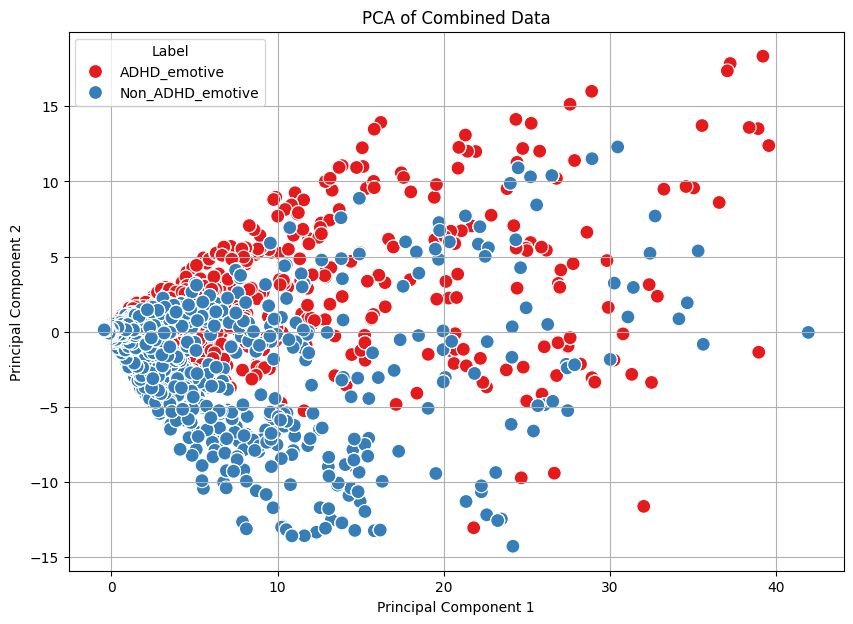

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Combine the principal components with the labels
final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)

print("Principal components (eigenvectors):")
print(pca.components_)

print("\nExplained variance ratio:")
print(pca.explained_variance_ratio_)

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df, x='principal_component_1', y='principal_component_2', hue='Label', palette='Set1', s=100)
plt.title('PCA of Combined Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

### LDA

Por lo que entendemos, LDA puede graficar en una dimensión en nuestro caso. Toma el mínimo entre las features (5) y la cantidad de clases - 1 (si tomamos solo ADHD vs non-ADHD, es 1). Si hago este grafico con histograma no llego a nada lindo, porque los dos grupos concentran sus datos en casi el mismo lugar.

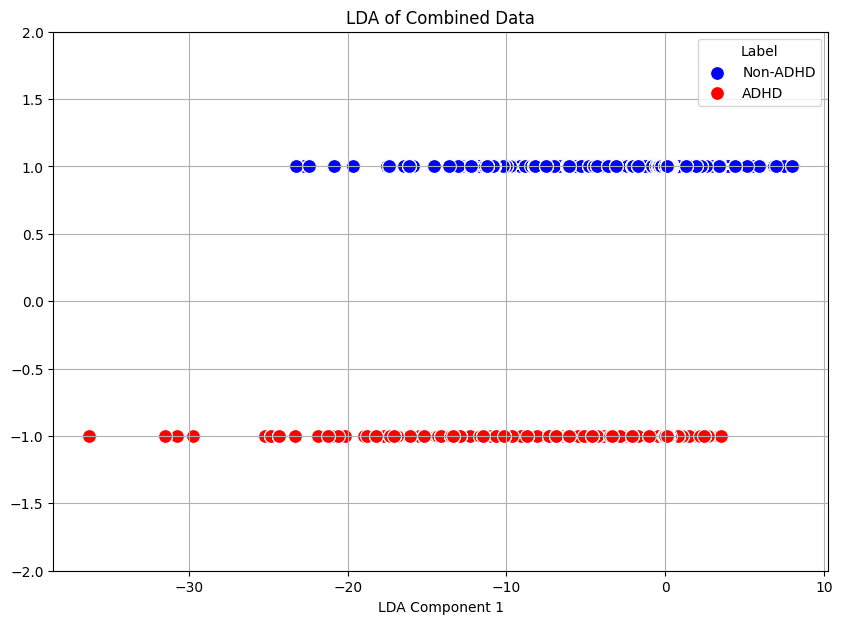

LDA coefficients:
[[-0.15049549  0.0452969   0.0857798  -0.20740394  0.09700832]]

Explained variance ratio:
[1.]


In [ ]:
lda = LDA(n_components=1)

# Fit and transform the data
lda_components = lda.fit_transform(x, y)

# Create a DataFrame with the LDA components
lda_df = pd.DataFrame(data=lda_components, columns=['lda_component_1'])

# Combine the LDA components with the labels
final_df = pd.concat([lda_df, y.reset_index(drop=True)], axis=1)

# Split the data based on the labels
non_adhd_data = final_df[final_df['Label'] == 'Non_ADHD_emotive']
adhd_data = final_df[final_df['Label'] == 'ADHD_emotive']

# Plot the LDA results
plt.figure(figsize=(10, 7))

# Plot non-ADHD data
sns.scatterplot(data=non_adhd_data, x='lda_component_1', y=np.ones(len(non_adhd_data)), color='blue', label='Non-ADHD', s=100)

# Plot ADHD data
sns.scatterplot(data=adhd_data, x='lda_component_1', y=-np.ones(len(adhd_data)), color='red', label='ADHD', s=100)

plt.title('LDA of Combined Data')
plt.xlabel('LDA Component 1')
plt.ylabel('')
plt.ylim(-2, 2)  # Adjust y-axis limits to separate the classes
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

# Print the LDA coefficients
print("LDA coefficients:")
print(lda.coef_)

# Print the explained variance ratio
explained_variance_ratio = lda.explained_variance_ratio_
print("\nExplained variance ratio:")
print(explained_variance_ratio)

### t-SNE

Por ahora estamos trabajando con subsets, ya que sino tarda dea

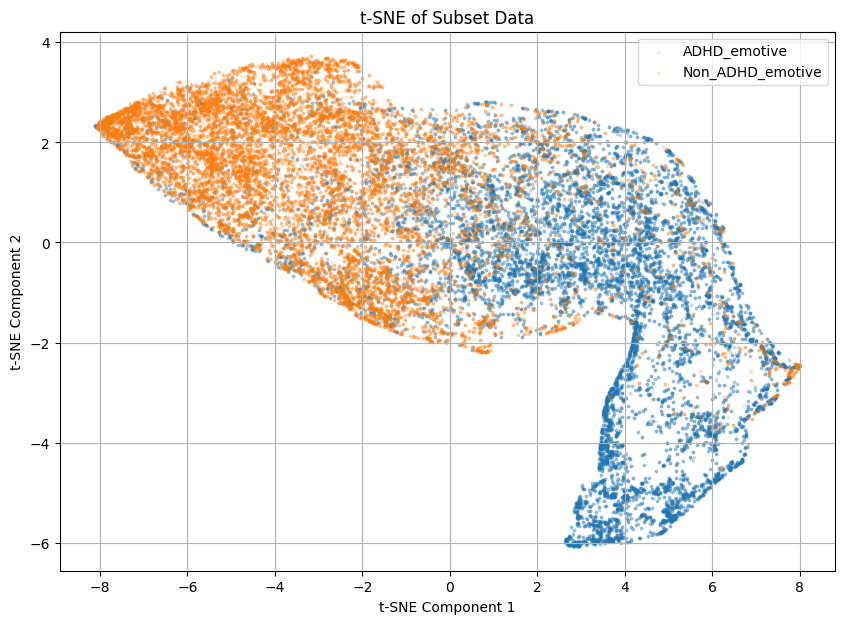

In [ ]:
subset_size_each = 35000

# Concatenate subsets from the beginning and end of the dataset
x_subset = np.concatenate((x[:subset_size_each], x[-subset_size_each:]), axis=0)

# Optionally add noise
# noise = np.random.normal(0, 0.0001, size=x_subset.shape)
# x_subset = x_subset + noise

# Instantiate the t-SNE model
tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=250
)

# Fit and transform the subset of data
tsne_components = tsne_model.fit_transform(x_subset)

# Create a DataFrame with the t-SNE components
tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

# Combine the t-SNE components with the labels
y_concatenated = pd.concat([y[:subset_size_each].reset_index(drop=True), y[-subset_size_each:].reset_index(drop=True)])
final_df_tsne = pd.concat([tsne_df, y_concatenated.reset_index(drop=True)], axis=1)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### UMAP

Ya voy 1 hora y 10 minutos. No se si estoy haciendo cualquier cosa, dejo esto escrito por si lo ves antes de que me levante. Claramente hay un tema con la cantidad de datos porque no llega ni a empezar a pasar las epochs. En el proximo codigo eligo subset y llego a algo lindo

In [ ]:
# Instantiate the UMAP model
umap_model = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    learning_rate=1.0,
    n_epochs=200,
    n_jobs=-1,
    verbose=True
)

# Fit and transform the data
umap_components = umap_model.fit_transform(x)

# Create a DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])

# Combine the UMAP components with the labels
final_df_umap = pd.concat([umap_df, y.reset_index(drop=True)], axis=1)

# Plot the UMAP results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df_umap, x='umap_component_1', y='umap_component_2', hue='Label', palette='Set1', s=100)
plt.title('UMAP of Combined Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

UMAP(n_epochs=200, verbose=True)
Sun Jun  2 15:09:31 2024 Construct fuzzy simplicial set
Sun Jun  2 15:09:31 2024 Finding Nearest Neighbors
Sun Jun  2 15:09:31 2024 Building RP forest with 27 trees
Sun Jun  2 15:09:39 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Sun Jun  2 15:10:07 2024 Finished Nearest Neighbor Search
Sun Jun  2 15:10:12 2024 Construct embedding


KeyboardInterrupt: 

Aca hago UMAP con subset para que por lo menos CORRA. Lo del ruido me lo pide cuando hago verbose, TODO check si esta bien o estoy modificando mucho la data. Si te tarda mucho correr hace subset<30k, n_neighbors <200 y n_epochs mas o menos 500.

UMAP(learning_rate=0.5, min_dist=0.2, n_epochs=600, n_neighbors=250, verbose=True)
Sun Jun  2 15:55:22 2024 Construct fuzzy simplicial set
Sun Jun  2 15:55:22 2024 Finding Nearest Neighbors
Sun Jun  2 15:55:22 2024 Building RP forest with 20 trees
Sun Jun  2 15:55:22 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Jun  2 15:58:47 2024 Finished Nearest Neighbor Search
Sun Jun  2 15:58:59 2024 Construct embedding


Epochs completed:   0%|            0/600 [00:00]

	completed  0  /  600 epochs
	completed  60  /  600 epochs
	completed  120  /  600 epochs
	completed  180  /  600 epochs
	completed  240  /  600 epochs
	completed  300  /  600 epochs
	completed  360  /  600 epochs
	completed  420  /  600 epochs
	completed  480  /  600 epochs
	completed  540  /  600 epochs
Sun Jun  2 16:06:01 2024 Finished embedding
<bound method DataFrame.info of        umap_component_1  umap_component_2
0             11.450563          6.142377
1              9.699357          6.654173
2              9.412097          6.980825
3             12.013465          5.933852
4             10.014164          7.010986
...                 ...               ...
89995         -3.732250          3.904839
89996         -4.920086          0.279308
89997         -3.791469         -0.502828
89998         -2.521574          4.347464
89999          0.317043          2.308012

[90000 rows x 2 columns]>
<bound method DataFrame.info of        umap_component_1  umap_component_2             

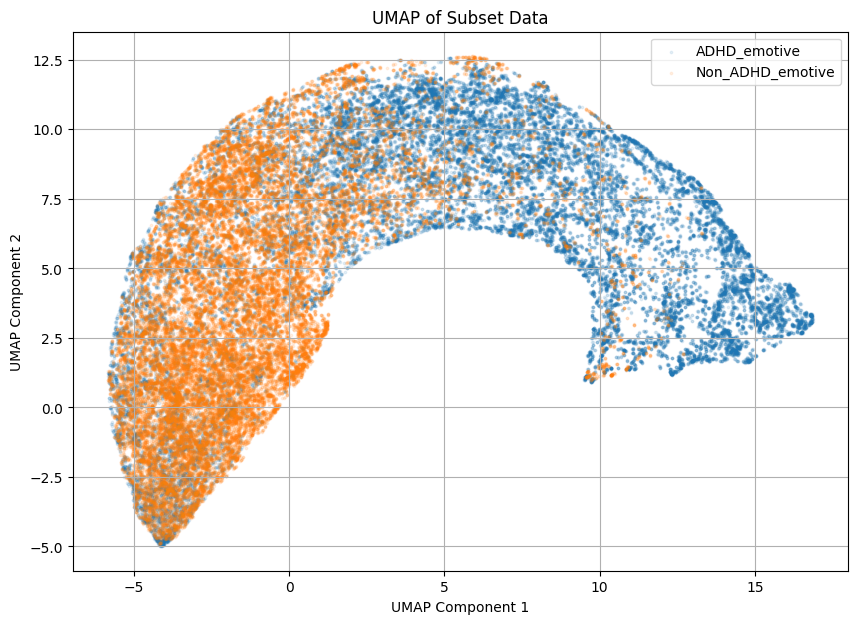

In [ ]:
subset_size_each = 45000
x_subset = np.concatenate((x[:subset_size_each], x[-subset_size_each:]), axis=0)
noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

# Instantiate the UMAP model
umap_model = UMAP(
    n_components=2,
    n_neighbors=250,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=600,
    n_jobs=-1,
    verbose=True
)

# Fit and transform the subset of data
umap_components = umap_model.fit_transform(x_subset)

# Create a DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])
print(umap_df.info)
# Combine the UMAP components with the labels
y_concatenated = pd.concat([y[:subset_size_each].reset_index(drop=True), y[-subset_size_each:].reset_index(drop=True)])
final_df_umap = pd.concat([umap_df, y_concatenated.reset_index(drop=True)], axis=1)

print(final_df_umap.info)


plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Espectrogramas

In [8]:
values = non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv']

In [9]:
values2 = adhd_emotive['ADHD/10/Emotiv/emo zeynep 5.csv']

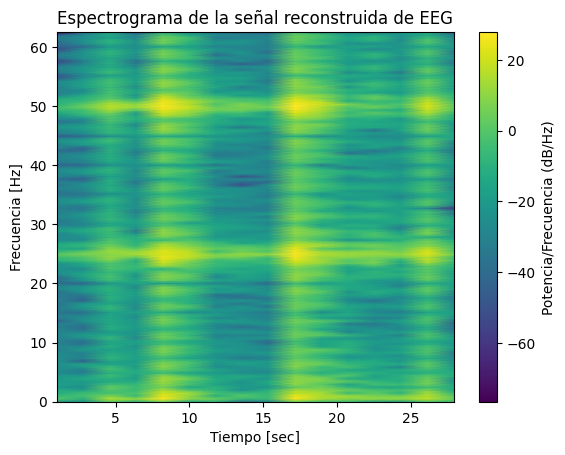

In [10]:
full_signal1 = values['Alpha'] + values['Theta'] + values['High_beta'] + values['Low_beta'] + values['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal1, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [sec]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Comentarios: se nota la banda característica de ruido de línea en todo el espectro a 50 Hz, que pareciera no estar filtrada por el color (potencia positiva). Sin embargo, tiene otras líneas que no sé a que atribuir (alrededor de 25 Hz y las otras verticales). Podría deberse a gaps según como hayan tomado las bandas frecuenciales.

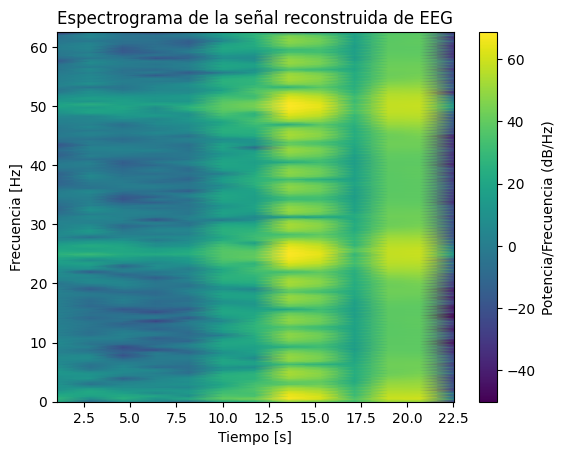

In [11]:
full_signal2 = values2['Alpha'] + values2['Theta'] + values2['High_beta'] + values2['Low_beta'] + values2['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal2, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Punto positivo: se ven distintos. Tiene sentido hacer espectrogramas así y después hacer PCA o LDA a ver que sale?

Citando el comentario de Facu: "Imagino que un PCA aplicado a los espectrogramas de las señales podría llegar a darles información acerca de la composición". La idea sería ver que bandas de frecuencia explican la mayor varianza? No entendemos bien como se aplica PCA al espectrograma.

Otras features que podemos usar, que son usuales en análisis de EEG, son: dimensión fractal, ICA, FFT, Wavelet Transform.

En próxima sección ploteamos dos señales a modo de ejemplo, de cada clase de sujeto. Se ven diferencias sustanciales en la amplitud, especialmente de los ritmos theta.

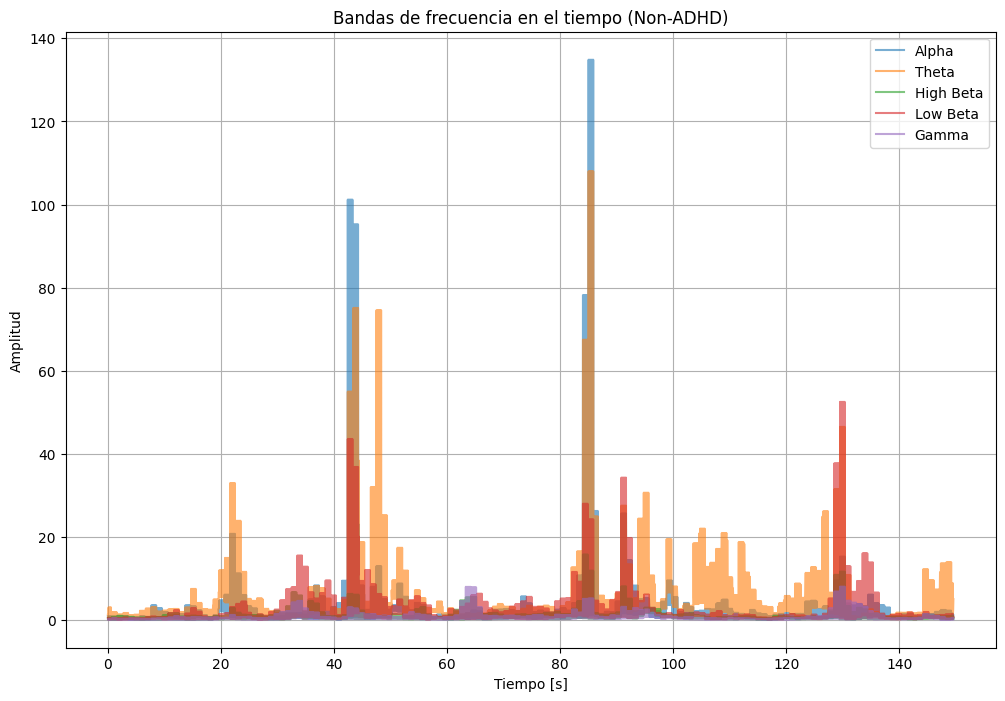

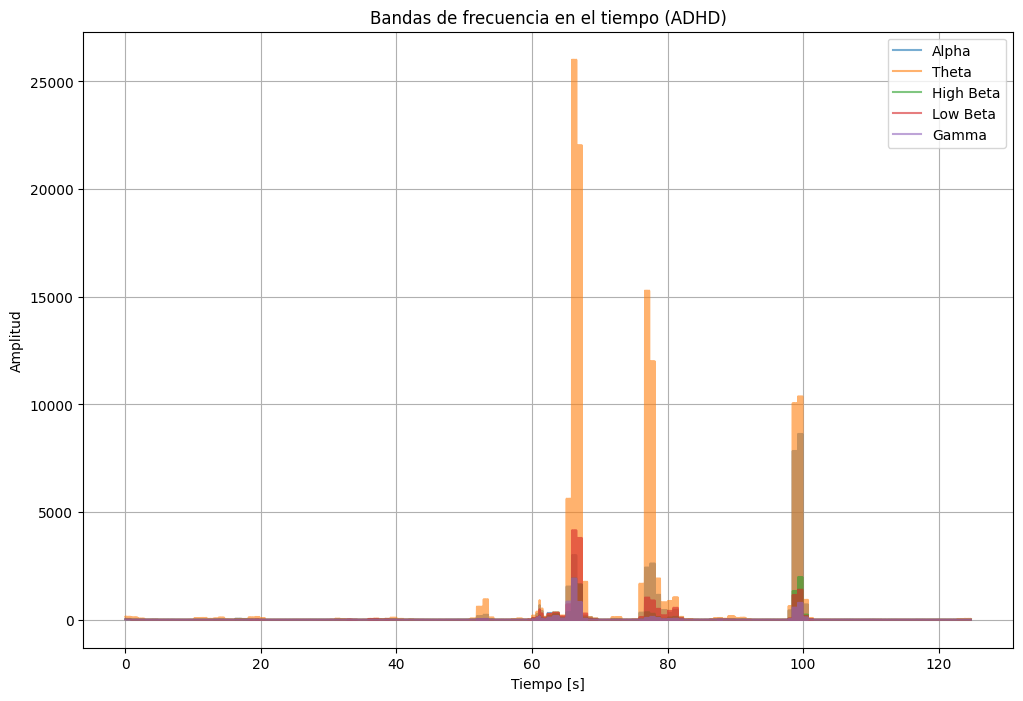

In [ ]:
# @title Ploteo
alpha = values['Alpha']
theta = values['Theta']
high_beta = values['High_beta']
low_beta = values['Low_beta']
gamma = values['Gamma']


fs = 125/5  # no sé si esto está bien, es fs/window size
t = values.index / fs

plt.figure(figsize=(12, 8))

plt.plot(t, alpha, label='Alpha', alpha=0.6)
plt.plot(t, theta, label='Theta', alpha=0.6)
plt.plot(t, high_beta, label='High Beta', alpha=0.6)
plt.plot(t, low_beta, label='Low Beta', alpha=0.6)
plt.plot(t, gamma, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (Non-ADHD)')
plt.legend()
plt.grid(True)

plt.show()

alpha2 = values2['Alpha']
theta2 = values2['Theta']
high_beta2 = values2['High_beta']
low_beta2 = values2['Low_beta']
gamma2 = values2['Gamma']

t = values2.index / fs


plt.figure(figsize=(12, 8))

plt.plot(t, alpha2, label='Alpha', alpha=0.6)
plt.plot(t, theta2, label='Theta', alpha=0.6)
plt.plot(t, high_beta2, label='High Beta', alpha=0.6)
plt.plot(t, low_beta2, label='Low Beta', alpha=0.6)
plt.plot(t, gamma2, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (ADHD)')
plt.legend()
plt.grid(True)

plt.show()


# plt.figure(figsize=(12, 8))

# plt.plot(t, full_signal1, label='Full Signal Non-ADHD', color='lightgreen', alpha=0.7)
# plt.plot(t, full_signal2, label='Full Signal ADHD', color='mediumpurple', alpha=0.7)


# plt.xlabel('Tiempo [s]')
# plt.ylabel('Amplitud')
# plt.title('Bandas de frecuencia en el tiempo comparadas')
# plt.legend()
# plt.grid(True)

# plt.show()